In [1]:
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
import pickle
import cv2
import glob
from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler
from skimage.feature import hog
import matplotlib.image as mpimg
from helper_funcs import *

In [2]:

#dist_pickle = pickle.load( open("svc_pickle.p", "rb" ) )
#svc = dist_pickle["svc"]
#X_scaler = dist_pickle["scaler"]
#orient = dist_pickle["orient"]
#pix_per_cell = dist_pickle["pix_per_cell"]
#cell_per_block = dist_pickle["cell_per_block"]
#spatial_size = dist_pickle["spatial_size"]
#hist_bins = dist_pickle["hist_bins"]

all_cars = []
all_notcars = []
for image in glob.iglob('**/*.png', recursive=True):
    if 'non-vehicle' in image:
        all_notcars.append(image)
    else:
        all_cars.append(image)


In [3]:
from sklearn.model_selection import train_test_split
import time
%matplotlib inline

color_space = 'YCrCb' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
orient = 9  # HOG orientations
pix_per_cell = 8 # HOG pixels per cell
cell_per_block = 2 # HOG cells per block
hog_channel = 'ALL' # Can be 0, 1, 2, or "ALL"
spatial_size = (16, 16) # Spatial binning dimensions
hist_bins = 16    # Number of histogram bins
spatial_feat = True # Spatial features on or off
hist_feat = True # Histogram features on or off
hog_feat = True # HOG features on or off
y_start_stop = [None, None] # Min and max in y to search in slide_window()

In [4]:
sample_size = 8792
#sample_size = 500
cars = all_cars[0:sample_size]
notcars = all_notcars[0:sample_size]
print(len(cars))
print(len(notcars))

8792
8792


In [ ]:
car_features = extract_features(cars, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat)
notcar_features = extract_features(notcars, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat)

X = np.vstack((car_features, notcar_features)).astype(np.float64)   
# Fit a per-column scaler
X_scaler = StandardScaler().fit(X)
# Apply the scaler to X
scaled_X = X_scaler.transform(X)

# Define the labels vector
y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))))


# Split up data into randomized training and test sets
rand_state = np.random.randint(0, 100)
X_train, X_test, y_train, y_test = train_test_split(
    scaled_X, y, test_size=0.2, random_state=rand_state)

print('Using:',orient,'orientations',pix_per_cell,
    'pixels per cell and', cell_per_block,'cells per block')
print('Feature vector length:', len(X_train[0]))
# Use a linear SVC 
svc = LinearSVC()
# Check the training time for the SVC
t=time.time()
svc.fit(X_train, y_train)
t2 = time.time()
print(round(t2-t, 2), 'Seconds to train SVC...')
# Check the score of the SVC
print('Test Accuracy of SVC = ', round(svc.score(X_test, y_test), 4))
# Check the prediction time for a single sample
t=time.time()


8792
8792
Using: 9 orientations 8 pixels per cell and 2 cells per block
Feature vector length: 6108


In [15]:
model_info = {}
model_info['svc'] = svc
model_info['X_scaler'] = X_scaler
pickle.dump( model_info, open( "model_info.p", "wb" ) )

previous parameters: 
svc:  LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=1000,
     multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
     verbose=0)
X_scaler:  StandardScaler(copy=True, with_mean=True, with_std=True)
orient:  9
pix_per_cell:  8
cel_per_block:  2
spatial_size:  (16, 16)
hist_bins:  16


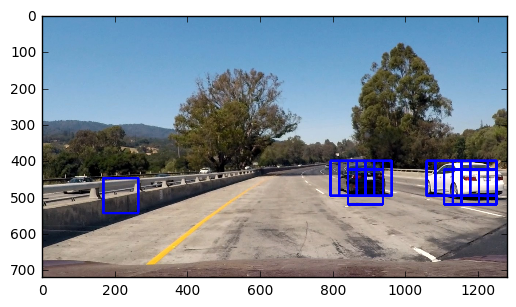

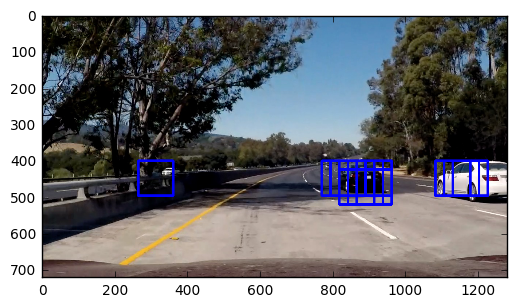

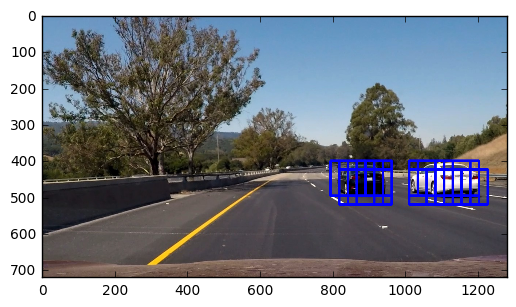

In [5]:
model_info = pickle.load( open("model_info.p", "rb" ) )
svc = model_info['svc']
X_scaler = model_info['X_scaler']
all_boxes = []


# Define a single function that can extract features using hog sub-sampling and make predictions
def find_cars(img, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins,
              find_mode, all_boxes):
    boxes = []
    draw_img = np.copy(img)
    img = img.astype(np.float32)/255
    
    img_tosearch = img[ystart:ystop,:,:]
    ctrans_tosearch = convert_color(img_tosearch, conv='RGB2YCrCb')
    if scale != 1:
        imshape = ctrans_tosearch.shape
        ctrans_tosearch = cv2.resize(ctrans_tosearch, (np.int(imshape[1]/scale), np.int(imshape[0]/scale)))
        
    ch1 = ctrans_tosearch[:,:,0]
    ch2 = ctrans_tosearch[:,:,1]
    ch3 = ctrans_tosearch[:,:,2]

    # Define blocks and steps as above
    nxblocks = (ch1.shape[1] // pix_per_cell)-1
    nyblocks = (ch1.shape[0] // pix_per_cell)-1 
    nfeat_per_block = orient*cell_per_block**2
    # 64 was the orginal sampling rate, with 8 cells and 8 pix per cell
    window = 64
    nblocks_per_window = (window // pix_per_cell)-1 
    cells_per_step = 2  # Instead of overlap, define how many cells to step
    nxsteps = (nxblocks - nblocks_per_window) // cells_per_step
    nysteps = (nyblocks - nblocks_per_window) // cells_per_step
    
    # Compute individual channel HOG features for the entire image
    hog1 = get_hog_features(ch1, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog2 = get_hog_features(ch2, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog3 = get_hog_features(ch3, orient, pix_per_cell, cell_per_block, feature_vec=False)
    
    for xb in range(nxsteps):
        for yb in range(nysteps):
            ypos = yb*cells_per_step
            xpos = xb*cells_per_step
            # Extract HOG for this patch
            hog_feat1 = hog1[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat2 = hog2[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat3 = hog3[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_features = np.hstack((hog_feat1, hog_feat2, hog_feat3))
            xleft = xpos*pix_per_cell
            ytop = ypos*pix_per_cell

            # Extract the image patch
            subimg = cv2.resize(ctrans_tosearch[ytop:ytop+window, xleft:xleft+window], (64,64))
          
            # Get color features
            spatial_features = bin_spatial(subimg, size=spatial_size)
            hist_features = color_hist(subimg, nbins=hist_bins)
            test_features = X_scaler.transform(np.hstack((spatial_features, hist_features, hog_features)).reshape(1, -1))    
            test_prediction = svc.predict(test_features)
            
            if test_prediction == 1:
                xbox_left = np.int(xleft*scale)
                ytop_draw = np.int(ytop*scale)
                win_draw = np.int(window*scale)
                if find_mode == 'SINGLE_PIC':
                    cv2.rectangle(draw_img,(xbox_left, ytop_draw+ystart),(xbox_left+win_draw,ytop_draw+win_draw+ystart),(0,0,255),6) 
                    boxes.append(((xbox_left, ytop_draw+ystart),(xbox_left+win_draw,ytop_draw+win_draw+ystart)))                 
                elif find_mode == 'VIDEO':
                    boxes.append(((xbox_left, ytop_draw+ystart),(xbox_left+win_draw,ytop_draw+win_draw+ystart)))
    all_boxes.append(boxes)
    return draw_img, all_boxes
    
ystart = 400
ystop = 656
scale = 1.5

print ('previous parameters: ')
print ('svc: ', svc)
print ('X_scaler: ', X_scaler)
print ('orient: ', orient)
print ('pix_per_cell: ', pix_per_cell)
print ('cel_per_block: ', cell_per_block)
print ('spatial_size: ', spatial_size)
print ('hist_bins: ', hist_bins) 

img1 = mpimg.imread('../ztemp/test1.jpg')  
out_img, boxes = find_cars(img1, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size,
                           hist_bins, 'SINGLE_PIC', all_boxes)
plt.imshow(out_img)
plt.imsave('../ztemp/temp/example1.jpg', out_img)

img2 = mpimg.imread('../ztemp/test5.jpg')  
out_img, boxex = find_cars(img2, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size,
                           hist_bins, 'SINGLE_PIC', all_boxes)
plt.figure()
plt.imshow(out_img)
plt.imsave('../ztemp/temp/example2.jpg', out_img)

img3 = mpimg.imread('../ztemp/test6.jpg')  
out_img, boxes = find_cars(img3, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size,
                           hist_bins, 'SINGLE_PIC', all_boxes)
plt.figure()
plt.imshow(out_img)
plt.imsave('../ztemp/temp/example3.jpg', out_img)
    

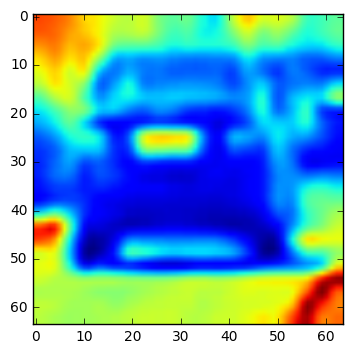

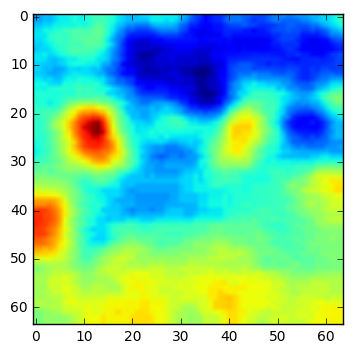

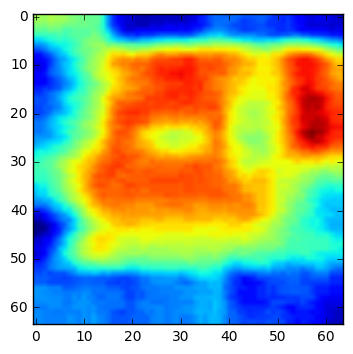

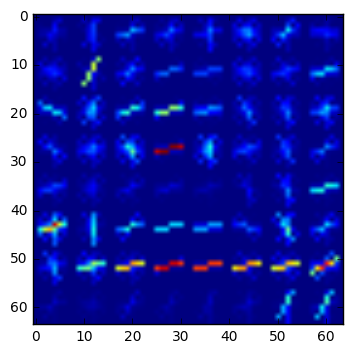

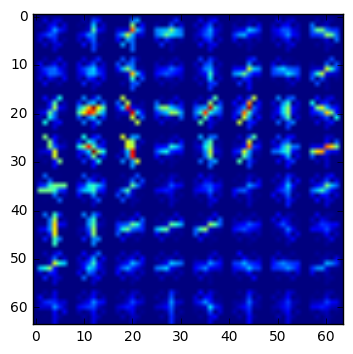

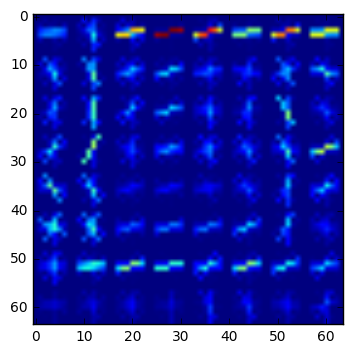

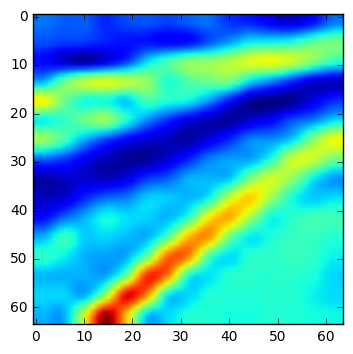

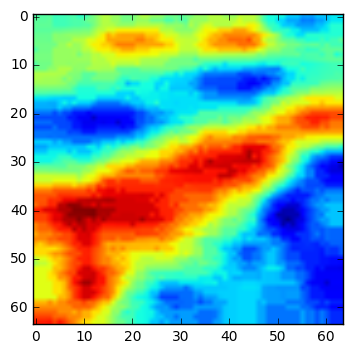

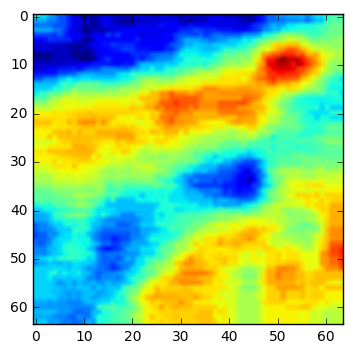

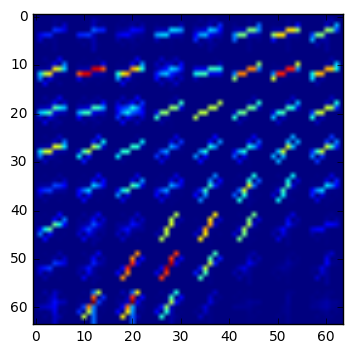

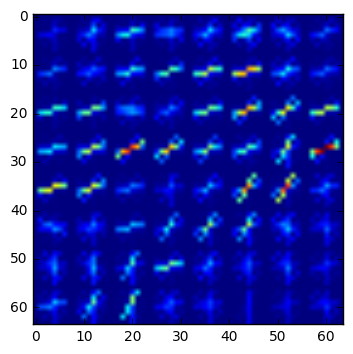

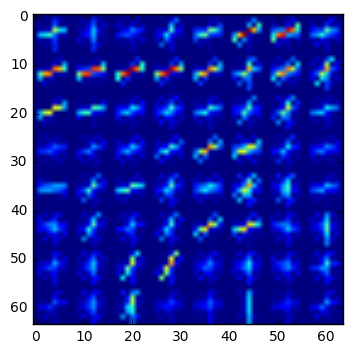

In [6]:
def draw_cars(img, img_type):
    gray_img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    img = convert_color(img, conv='RGB2YCrCb')    
    imgs = []
    names = ['ch1 '+img_type,'ch2 '+img_type,'ch3 '+img_type, 'ch1 HOG '+img_type, 'ch2 HOG '+img_type, 'ch3 HOG '+img_type]
    ch1 = img[:,:,0]
    ch2 = img[:,:,1]
    ch3 = img[:,:,2]
    
    hog1 = get_hog_features(ch1, orient, pix_per_cell, cell_per_block, vis=True, feature_vec=True)
    hog2 = get_hog_features(ch2, orient, pix_per_cell, cell_per_block, vis=True, feature_vec=True)
    hog3 = get_hog_features(ch3, orient, pix_per_cell, cell_per_block, vis=True, feature_vec=True)
    
    imgs.extend((ch1,ch2,ch3,hog1[1],hog2[1],hog3[1]))

    for inx, img in enumerate(imgs):
        plt.imsave('../ztemp/temp/'+names[inx] + '.png', img)
        plt.figure()
        plt.imshow(img)
        
car = mpimg.imread('../ztemp/temp/image0000.png') 
car = car.astype(np.float32)/255
not_car = mpimg.imread('../ztemp/temp/image6.png')
not_car = not_car.astype(np.float32)/255

draw_cars(car, 'car')
draw_cars(not_car, 'Not car')

In [7]:
def add_heat(heatmap, bbox_list):
    # Iterate through list of bboxes
    for box in bbox_list:
        # Add += 1 for all pixels inside each bbox
        # Assuming each "box" takes the form ((x1, y1), (x2, y2))
        heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1

    # Return updated heatmap
    return heatmap# Iterate through list of bboxes
    
def apply_threshold(heatmap, threshold):
    # Zero out pixels below the threshold
    heatmap[heatmap <= threshold] = 0
    # Return thresholded map
    return heatmap

def draw_labeled_bboxes(img, labels):
    # Iterate through all detected cars
    for car_number in range(1, labels[1]+1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        # Draw the box on the image
        cv2.rectangle(img, bbox[0], bbox[1], (0,0,255), 6)
    # Return the image
    return img


In [8]:
#cut the clip
from moviepy.video.io.ffmpeg_tools import ffmpeg_extract_subclip
ffmpeg_extract_subclip("project_video.mp4", 38, 40, targetname="cut_video_heat.mp4")


[MoviePy] Running:
>>> C:\Users\owner\AppData\Local\imageio\ffmpeg\ffmpeg.win32.exe -y -i project_video.mp4 -ss 38.00 -t 2.00 -vcodec copy -acodec copy cut_video_heat.mp4
... command successful.


In [9]:
vidcap = cv2.VideoCapture('cut_video_heat.mp4')
success,image = vidcap.read()
count = 0
success = True
while success and count<10:
  success,image = vidcap.read()
  print ('Read a new frame: ', success)
  cv2.imwrite("heat_frame%d.jpg" % count, image)     # save frame as JPEG file
  count += 1

Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True


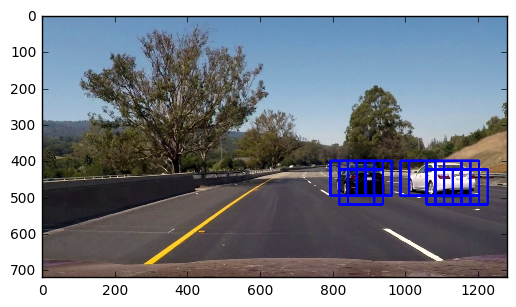

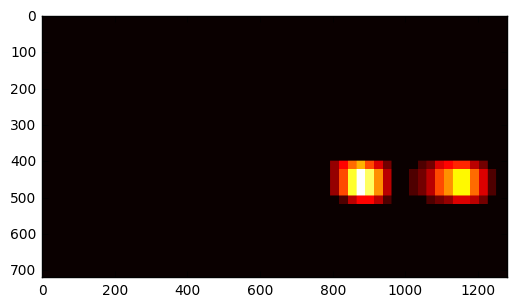

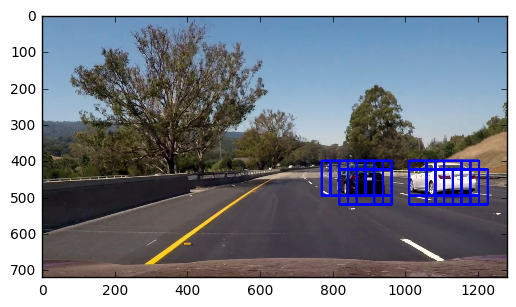

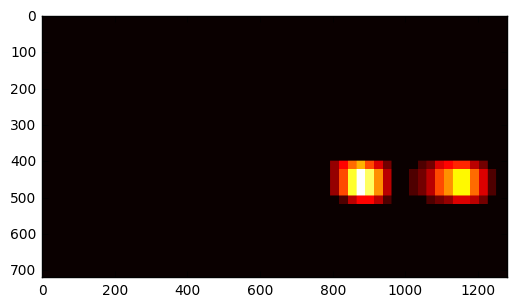

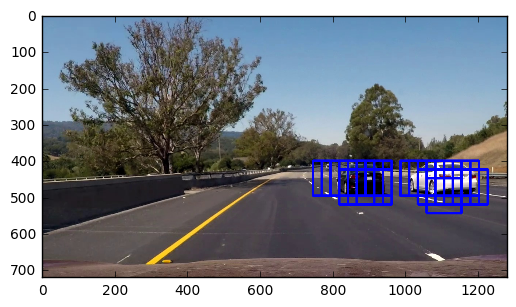

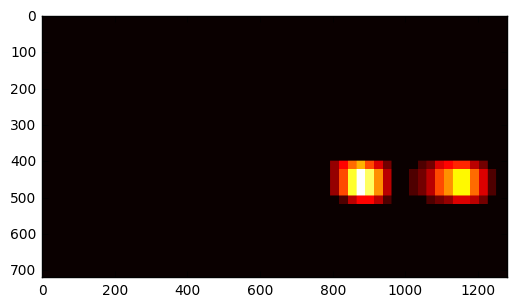

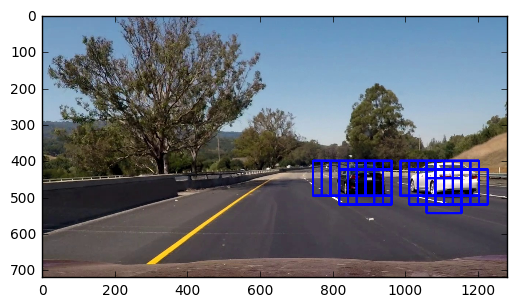

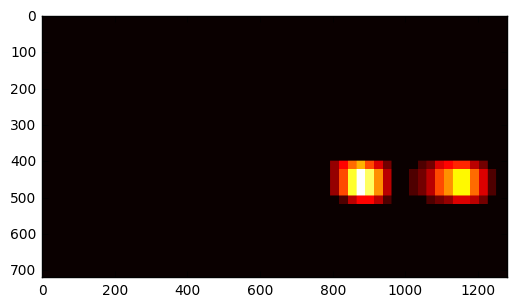

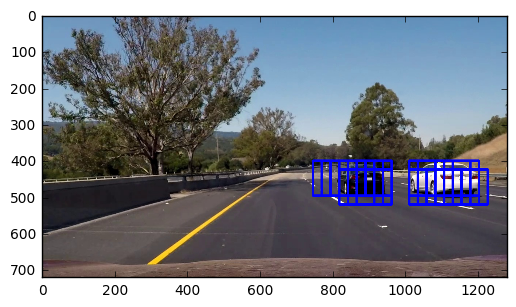

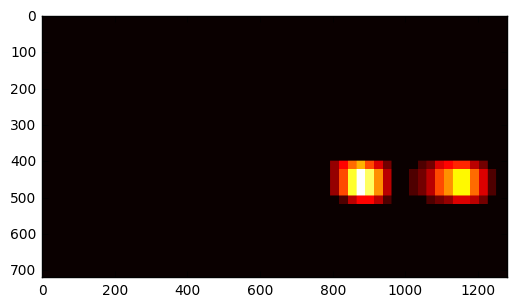

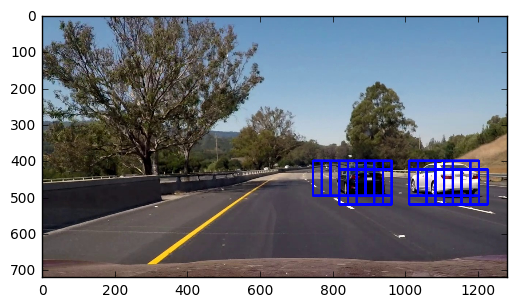

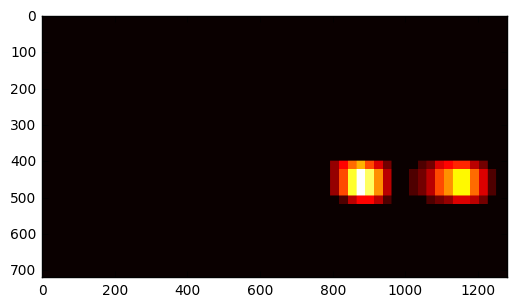

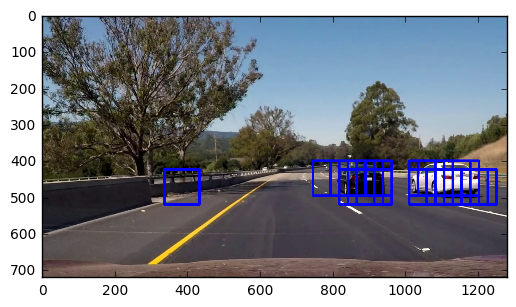

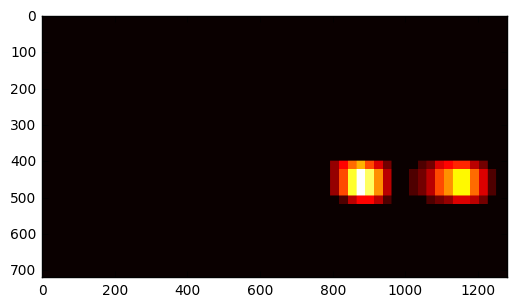

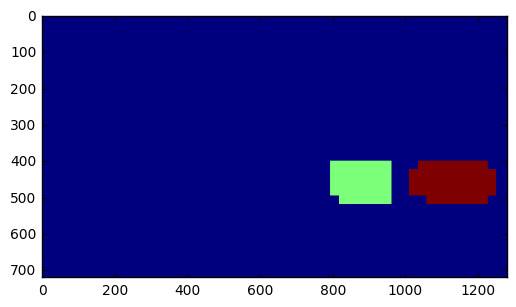

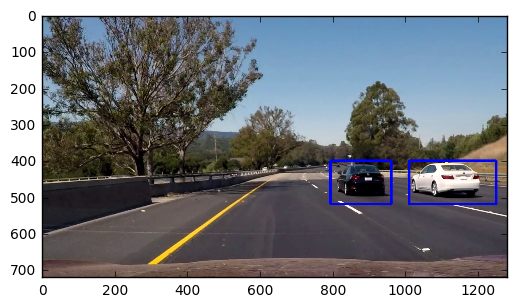

In [18]:
from scipy.ndimage.measurements import label


frames = ['heat_frame0.jpg','heat_frame1.jpg','heat_frame2.jpg','heat_frame3.jpg','heat_frame4.jpg','heat_frame5.jpg',
             'heat_frame6.jpg']

def show_heat(img, all_boxes):
    heat = np.zeros_like(img[:,:,0]).astype(np.float)
    boxes_list = [item for sublist in boxes for item in sublist]
    # Add heat to each box in box list
    heat = add_heat(heat,boxes_list)
    # Apply threshold to help remove false positives
    heat = apply_threshold(heat,1)
    # Visualize the heatmap when displaying    
    heatmap = np.clip(heat, 0, 255)
    # Find final boxes from heatmap using label function
    labels = label(heatmap)
    draw_img = draw_labeled_bboxes(np.copy(img), labels)    
    return heatmap, draw_img, labels[0]

#heatmap, out_img, label = show_heat(img1, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size,
#              hist_bins, all_boxes)

all_boxes = []
for inx, frame in enumerate(frames):
    img = mpimg.imread(frame)  
    out_img, all_boxes = find_cars(img, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size,
                           hist_bins, 'SINGLE_PIC', all_boxes)
    heatmap, draw_img, labels = show_heat(img, all_boxes)
    plt.figure()
    plt.imshow(out_img)
    plt.imsave('../ztemp/temp/boxed_frame'+str(inx)+'.jpg', out_img)    
    plt.figure()
    plt.imshow(heatmap, cmap='hot')
    plt.imsave('../ztemp/temp/heatmap'+str(inx)+'.jpg', heatmap)

heatmap, draw_img, label = show_heat(img, all_boxes)

plt.figure()
plt.imshow(label)
plt.imsave('../ztemp/temp/label_img.jpg', label)

plt.figure()
plt.imshow(draw_img)
plt.imsave('../ztemp/temp/draw_img.jpg', draw_img)
    


In [39]:
from scipy.ndimage.measurements import label
all_boxes = []
def pipe_line(img, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size,
              hist_bins, all_boxes):
    #img = img.astype(np.float32)/255
    out_img, boxes = find_cars(img, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size,
                           hist_bins, 'VIDEO', all_boxes)
    #all_boxes.append(boxes)
    #print(boxes)
    heat = np.zeros_like(img[:,:,0]).astype(np.float)
    boxes_list = [item for sublist in boxes for item in sublist]
    # Add heat to each box in box list
    heat = add_heat(heat,boxes_list)
    # Apply threshold to help remove false positives
    heat = apply_threshold(heat,9)
    # Visualize the heatmap when displaying    
    heatmap = np.clip(heat, 0, 255)
    # Find final boxes from heatmap using label function
    labels = label(heatmap)
    draw_img = draw_labeled_bboxes(np.copy(img), labels)
    if(len(all_boxes) > 15):
        all_boxes.pop(0)
    return draw_img

In [40]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [41]:
def process_image(img):
    result = pipe_line(img, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size,
              hist_bins, all_boxes)
    return result

In [42]:
#cut the clip this is for cutting the process time and try different parameters
from moviepy.video.io.ffmpeg_tools import ffmpeg_extract_subclip
ffmpeg_extract_subclip("project_video.mp4", 20, 23, targetname="cut_video_heat.mp4")


[MoviePy] Running:
>>> C:\Users\owner\AppData\Local\imageio\ffmpeg\ffmpeg.win32.exe -y -i project_video.mp4 -ss 20.00 -t 3.00 -vcodec copy -acodec copy cut_video_heat.mp4
... command successful.


In [43]:
white_output = 'processed.mp4'
clip1 = VideoFileClip("project_video.mp4")
white_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)

[MoviePy] >>>> Building video processed_9_15.mp4
[MoviePy] Writing video processed_9_15.mp4


100%|█████████████████████████████████████▉| 1260/1261 [08:40<00:00,  2.65it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: processed_9_15.mp4 

Wall time: 8min 42s
